In [7]:
using  Plots, Optim, Dates, DiffEqParamEstim, Flux, DiffEqFlux, OrdinaryDiffEq, MAT, Statistics, LinearAlgebra

In [8]:
# siControl B55=1.0, MASTL=1.0
CCNB1 = [-0.04629629629629761 1.0000145815106447;
10 0.8598643919510063;
15 0.6291557305336833;
16.990740740740744 0.506634587343249;
18.98148148148148 0.3998614756488773;
20.97222222222222 0.28363954505686795;
23.055555555555554 0.1863298337707786;
24.999999999999996 0.08269903762029762;
27.083333333333332 0.04365704286964123;
29.166666666666668 0.026662292213473382;
31.15740740740741 0.020676582093904994;
33.19444444444444 0.019422572178477537;
35.138888888888886 0.011854768153980677;
37.175925925925924 0.013750364537766346;
39.21296296296296 0.00934674832312643;
41.20370370370371 0.011235053951589302;
43.19444444444444 0.011548556430446055;
45.23148148148148 0.015018955963838065]

pMPS1 = [-0.09259259259259522 0.8551254009915429;
9.953703703703702 0.8708807232429281;
14.953703703703706 0.8685185185185187;
16.990740740740744 0.8373432487605718;
18.98148148148148 0.8156095071449404;
21.064814814814813 0.8395596383785362;
23.055555555555554 0.7438101487314087;
25.0462962962963 0.6811315252260135;
27.083333333333332 0.6200349956255469;
29.12037037037037 0.4786235053951591;
31.11111111111111 0.4647637795275591;
33.14814814814815 0.38949402158063584;
35.18518518518519 0.22603528725575983;
37.12962962962963 0.17437299504228632;
39.12037037037037 0.11799358413531658;
41.157407407407405 0.0379994167395743;
43.14814814814814 0.038312919218431274;
45.18518518518519 0.02131087780694063]

pENSA = [-0.09259259259259522 0.8409521726450861;
9.953703703703702 0.7196996208807235;
14.953703703703706 0.6921405657626131;
17.037037037037038 0.7365631379410909;
19.074074074074073 0.7242855059784195;
21.01851851851852 0.6474263633712454;;
23.055555555555554 0.5674321959755031;
25.09259259259259 0.4779892096821232;
27.083333333333332 0.3901137357830272;
29.12037037037037 0.46130067074948977;
31.296296296296294 0.33408428113152533;
33.10185185185185 0.265077282006416;
35.23148148148148 0.15832604257801108;
37.222222222222214 0.15391513560804881;
39.16666666666667 0.03453630796150464;
41.111111111111114 0.039566929133858286;
43.19444444444444 0.041469816272965865;
45.23148148148148 0.021318168562262985];

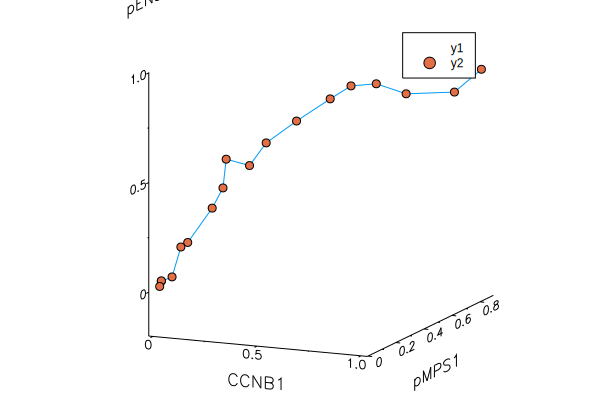

In [25]:
a = CCNB1[:,2]
b = pMPS1[:,2]
c = pENSA[:,2]

plt=plot(a,b,c, xlab = "CCNB1", ylab = "pMPS1", zlab  = "pENSA", grid = "off")
scatter!(a,b,c)


In [28]:
# Observed data
ode_data = transpose(hcat( a,b,c))
u0 = ode_data[:,1]
tspan = (0.,1.)
t = CCNB1[:,1].+abs(CCNB1[1])
t = t./t[end]
species = ["CCNB1", "pMPS1", "pENSA"];u0

3-element Array{Float64,1}:
 1.0000145815106447
 0.8551254009915429
 0.8409521726450861

In [11]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()), n_epochs)
    count_epochs = 0
    return saver(losses, l2s, times, count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

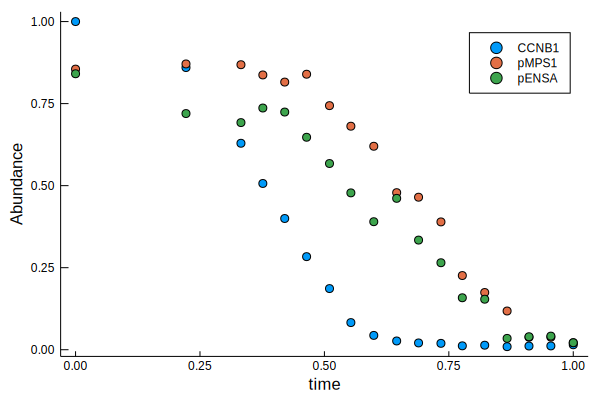

In [12]:

scatter(t, ode_data[1,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[1])
#plot!(t, ode_data[1,:], label = species[1])

scatter!(t, ode_data[2,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[2])
#plot!(t, ode_data[2,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[2])

scatter!(t, ode_data[3,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[3])
#plot!(t, ode_data[3,:], grid = "off", xlab = "time", ylab = "Abundance", label = species[3])


In [13]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(3,80,tanh),
       Dense(80,80,tanh),
       Dense(80,80,tanh),
       Dense(80,3))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_,x,tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
# Rosenbrock23, TRBDF2, ABDF2, Rodas5, Rodas4P, Kvaerno5, KenCarp4, CVODE_BDF (not defined)
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Rosenbrock23(autodiff=false), reltol=1e-7, abstol=1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Rosenbrock23(autodiff=false), saveat=t, reltol=1e-7, abstol=1e-9)
n_epochs = 300
verify = 10 # for <verify>th epoch the L2 is calculated  
data1 = Iterators.repeated((), n_epochs)
opt1 = ADAM(0.0001)

L2_loss_fct() = sum(abs2,ode_data .- n_ode(u0))
# Callback function to observe two stage training.
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()), Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()),0, Dates.Time(Dates.now()))
        # println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end

#7 (generic function with 1 method)

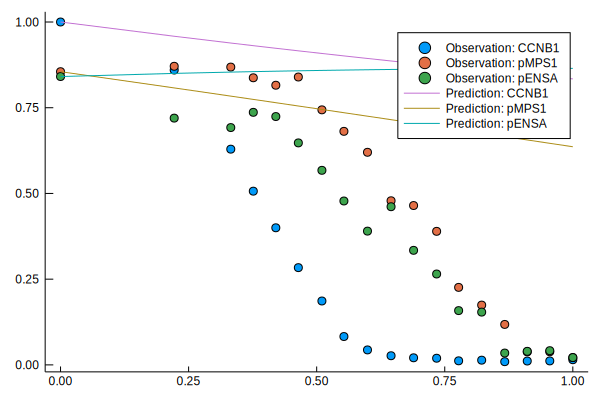

In [14]:
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = string("Observation: ", species[1]), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species[2]), grid = "off")
scatter!(t, ode_data[3,:], label = string("Observation: ", species[3]))
#scatter!(t, ode_data[4,:], label = string("Observation: ", species4))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species[1]))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species[2]))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species[3]))
#plot!(t, Flux.data(pred[4,:]), label = string("Prediction: ", species4))

In [15]:
sa = saver(n_epochs)
# train n_ode with collocation method
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

 21.250925 seconds (45.32 M allocations: 11.230 GiB, 10.41% gc time)


In [21]:
pred = n_ode(u0)
#scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter(t, ode_data[1,:], label = string("Observation: ", species[1]), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species[2]))
scatter!(t, ode_data[3,:], label = string("Observation: ", species[3]))
#plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species[1]))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species[2]))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species[3]))

Tracked 3×18 Array{Float64,2}:
 1.00001   0.816544  0.674027  0.609082  …  -0.129287   -0.134456   
 0.855125  0.916927  0.902425  0.885845      0.128296    0.0596301  
 0.840952  0.738038  0.66966   0.638232      0.0409488  -0.000451031

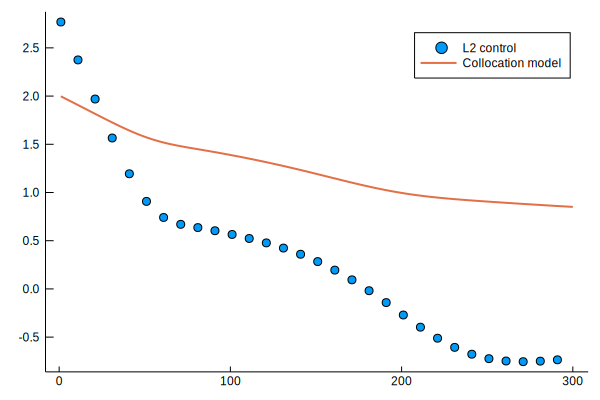

In [17]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s

In [18]:
# train n_ode with collocation method
sa = saver(n_epochs)
@time Flux.train!(two_stage_loss_fct, ps, data1, opt1, cb = cb1)

 22.071951 seconds (40.88 M allocations: 15.918 GiB, 11.41% gc time)


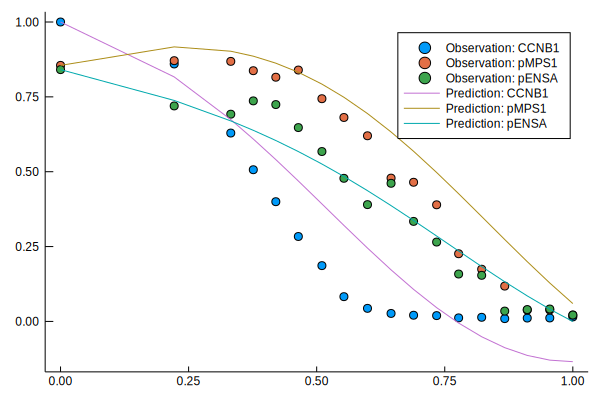

In [19]:
pred = n_ode(u0)
#scatter(t, ode_data[1,:], label = string("Observation: ", species1), grid = "off")
scatter(t, ode_data[1,:], label = string("Observation: ", species[1]), grid = "off")
scatter!(t, ode_data[2,:], label = string("Observation: ", species[2]))
scatter!(t, ode_data[3,:], label = string("Observation: ", species[3]))
#plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species1))
plot!(t, Flux.data(pred[1,:]), label = string("Prediction: ", species[1]))
plot!(t, Flux.data(pred[2,:]), label = string("Prediction: ", species[2]))
plot!(t, Flux.data(pred[3,:]), label = string("Prediction: ", species[3]))

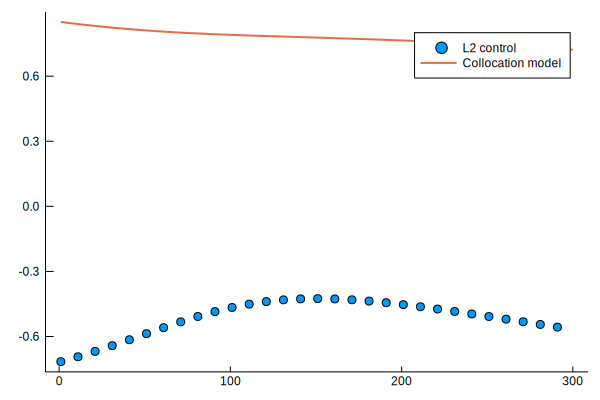

In [20]:
header = string("Collocation model")
scatter(range(1, stop = length(sa.l2s)), log.(sa.l2s), width  = 2, label = "L2 control", grid = "off")
plot!(range(1, stop = length(sa.losses)), log.(sa.losses), width  = 2, label = header)
# 5% of time even with l2s